CMPE 257: ML

Daniel Xinye Zhang

SJSU ID: 017471818

Assignment: [Project] Model Selection and Evaluation

Please fit ML models, compare and contrast the results. This component is solely graded on the model selection, tuning and model evaluation.


# Code

## Necessary imports and libraries (Note that this was ran on VSC on my local computer to speed up training times)

In [ ]:
import pandas as pd
import numpy as np
import os
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split


## Read in data file and load into array, set file paths for results, split data into training, validation, and testing sets

In [ ]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("balanced-all.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [ ]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [ ]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

## First model: Multilayered Perceptrion model and Training code

Contains model creation, training, and analysis

In [ ]:
# MLP
def create_mlp_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [ ]:
# construct the model
model = create_mlp_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [ ]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir='logs/mlp_logs/')
# define early stopping to stop training after 7 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=7, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 5s 5ms/step - loss: 0.5550 - accuracy: 0.7752 - val_loss: 0.3783 - val_accuracy: 0.8526
Epoch 2/100
848/848 [==============================] - 4s 5ms/step - loss: 0.4154 - accuracy: 0.8366 - val_loss: 0.3512 - val_accuracy: 0.8606
Epoch 3/100
848/848 [==============================] - 4s 5ms/step - loss: 0.3794 - accuracy: 0.8546 - val_loss: 0.3162 - val_accuracy: 0.8759
Epoch 4/100
848/848 [==============================] - 4s 5ms/step - loss: 0.3610 - accuracy: 0.8624 - val_loss: 0.3074 - val_accuracy: 0.8817
Epoch 5/100
848/848 [==============================] - 4s 5ms/step - loss: 0.3472 - accuracy: 0.8670 - val_loss: 0.2961 - val_accuracy: 0.8793
Epoch 6/100
848/848 [==============================] - 4s 5ms/step - loss: 0.3393 - accuracy: 0.8700 - val_loss: 0.2891 - val_accuracy: 0.8838
Epoch 7/100
848/848 [==============================] - 4s 5ms/step - loss: 0.3264 - accuracy: 0.8753 - val_loss: 0.2821 - val_accuracy: 0.8845

## Second model: Convolutional Neural Net model and Training code

Contains model creation, training, and analysis

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

def create_cnn_model(vector_length=128):
    """Simple 1D CNN with Conv1D and MaxPooling1D layers."""
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(vector_length, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

    # Print the model summary
    model.summary()
    return model


In [ ]:
# construct the model
cnn_model = create_cnn_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 dropout_10 (Dropout)        (None, 63, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 30, 128)          

In [ ]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir='logs/cnn_logs/')
# define early stopping to stop training after 7 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=7, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
cnn_model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 10s 5ms/step - loss: 0.4316 - accuracy: 0.8111 - val_loss: 0.2776 - val_accuracy: 0.8853
Epoch 2/100
848/848 [==============================] - 4s 5ms/step - loss: 0.3013 - accuracy: 0.8803 - val_loss: 0.2347 - val_accuracy: 0.9095
Epoch 3/100
848/848 [==============================] - 4s 5ms/step - loss: 0.2680 - accuracy: 0.8941 - val_loss: 0.2179 - val_accuracy: 0.9150
Epoch 4/100
848/848 [==============================] - 4s 5ms/step - loss: 0.2491 - accuracy: 0.9017 - val_loss: 0.2102 - val_accuracy: 0.9202
Epoch 5/100
848/848 [==============================] - 5s 6ms/step - loss: 0.2367 - accuracy: 0.9084 - val_loss: 0.1927 - val_accuracy: 0.9260
Epoch 6/100
848/848 [==============================] - 5s 6ms/step - loss: 0.2265 - accuracy: 0.9124 - val_loss: 0.1984 - val_accuracy: 0.9230
Epoch 7/100
848/848 [==============================] - 7s 8ms/step - loss: 0.2154 - accuracy: 0.9186 - val_loss: 0.1754 - val_accuracy: 0.936

## Third model: RNN model and Training code

Contains model creation, training, and analysis

In [ ]:
from keras.layers import SimpleRNN

def create_rnn_model(vector_length=128):
    """Simple RNN model using SimpleRNN layers."""
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(vector_length, 1), return_sequences=True))
    model.add(Dropout(0.3))

    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dropout(0.3))

    # Dense layer
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

    # Print the model summary
    model.summary()
    return model


In [ ]:
# construct the model
rnn_model = create_rnn_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128, 128)          16640     
                                                                 
 dropout_14 (Dropout)        (None, 128, 128)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [ ]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir='logs/rnn_logs')
# define early stopping to stop training after 7 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=7, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
rnn_model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 228s 269ms/step - loss: 0.6883 - accuracy: 0.5245 - val_loss: 0.6854 - val_accuracy: 0.5431
Epoch 2/100
848/848 [==============================] - 216s 255ms/step - loss: 0.6875 - accuracy: 0.5294 - val_loss: 0.6928 - val_accuracy: 0.4986
Epoch 3/100
848/848 [==============================] - 231s 273ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 4/100
848/848 [==============================] - 234s 276ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 5/100
848/848 [==============================] - 254s 300ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 6/100
848/848 [==============================] - 258s 304ms/step - loss: 0.6933 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5014
Epoch 7/100
848/848 [==============================] - 232s 273ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

## Fourth model: Transformer model and Training code


Contains model creation, training, and analysis

In [ ]:
from keras.layers import MultiHeadAttention, LayerNormalization, Add, Dense, Dropout, Input, Reshape, Flatten
from keras.models import Model

def create_transformer_model(vector_length=128, num_heads=4):
    """Simple Transformer-based model."""

    # Define the input layer
    input_layer = Input(shape=(vector_length,))

    # Transform the input to match the expected dimension for MultiHeadAttention
    dense_input = Dense(vector_length)(input_layer)
    reshaped_input = Reshape((vector_length, 1))(dense_input)  # Reshape to (vector_length, 1)

    # Self-attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=vector_length)(reshaped_input, reshaped_input)
    attention_output = Flatten()(attention_output)  # Flatten back for dense layers
    attention_output = Dense(vector_length)(attention_output)  # Ensure the output shape matches the input layer

    # Combine the original input with the attention output
    combined_output = Add()([dense_input, attention_output])
    combined_output = LayerNormalization()(combined_output)

    # Dense layer
    dense_output = Dense(64, activation="relu")(combined_output)
    dense_output = Dropout(0.3)(dense_output)

    # Output layer
    output = Dense(1, activation="sigmoid")(dense_output)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

    # Print the model summary
    model.summary()
    return model


In [ ]:
# construct the model
t_model = create_transformer_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_24 (Dense)               (None, 128)          16512       ['input_5[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 128, 1)       0           ['dense_24[0][0]']               
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 128, 1)      3585        ['reshape_1[0][0]',              
 eadAttention)                                                    'reshape_1[0][0]']          

In [ ]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir='logs/t_logs')
# define early stopping to stop training after 7 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=7, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
t_model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 8s 9ms/step - loss: 0.3520 - accuracy: 0.8508 - val_loss: 0.2886 - val_accuracy: 0.8845
Epoch 2/100
848/848 [==============================] - 7s 8ms/step - loss: 0.2948 - accuracy: 0.8810 - val_loss: 0.2665 - val_accuracy: 0.8924
Epoch 3/100
848/848 [==============================] - 7s 8ms/step - loss: 0.2746 - accuracy: 0.8910 - val_loss: 0.2634 - val_accuracy: 0.8928
Epoch 4/100
848/848 [==============================] - 7s 8ms/step - loss: 0.2631 - accuracy: 0.8961 - val_loss: 0.2504 - val_accuracy: 0.9019
Epoch 5/100
848/848 [==============================] - 7s 8ms/step - loss: 0.2542 - accuracy: 0.8988 - val_loss: 0.2389 - val_accuracy: 0.9087
Epoch 6/100
848/848 [==============================] - 7s 8ms/step - loss: 0.2476 - accuracy: 0.9034 - val_loss: 0.2430 - val_accuracy: 0.9080
Epoch 7/100
848/848 [==============================] - 7s 8ms/step - loss: 0.2406 - accuracy: 0.9070 - val_loss: 0.2318 - val_accuracy: 0.9092

# Model analysis and selection

## MLP Analysis

### Model Architecture and Parameters
```
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense_71 (Dense)            (None, 256)               33024     
                                                                 
 dropout_55 (Dropout)        (None, 256)               0         
                                                                 
 dense_72 (Dense)            (None, 256)               65792     
                                                                 
 dropout_56 (Dropout)        (None, 256)               0         
                                                                 
 dense_73 (Dense)            (None, 128)               32896     
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 128)               16512     
                                                                 
 dropout_58 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 64)                8256      
                                                                 
 dropout_59 (Dropout)        (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 1)                 65        
...
Total params: 156,545
Trainable params: 156,545
Non-trainable params: 0
```



### Model Accuracy
Early stopping conditions (7 iterations without major improvements) met at Epoch 48.
```
Epoch 48/100
848/848 [==============================] - 4s 5ms/step - loss: 0.2463 - accuracy: 0.9098 - val_loss: 0.2195 - val_accuracy: 0.9213
```



In [ ]:
# evaluating the multilayered perceptron model using the testing set
print(f"Evaluating the multilayered perceptron model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the multilayered perceptron model using 6694 samples...
Loss: 0.2233
Accuracy: 92.01%


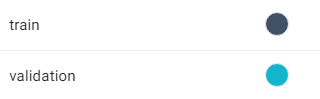

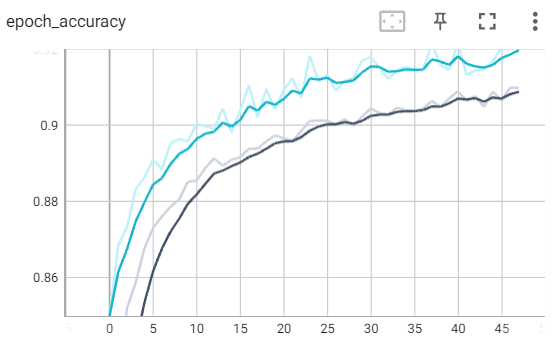

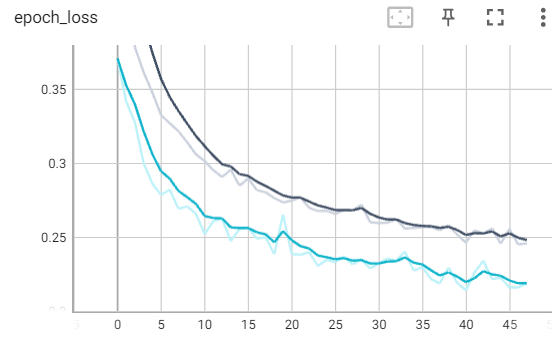

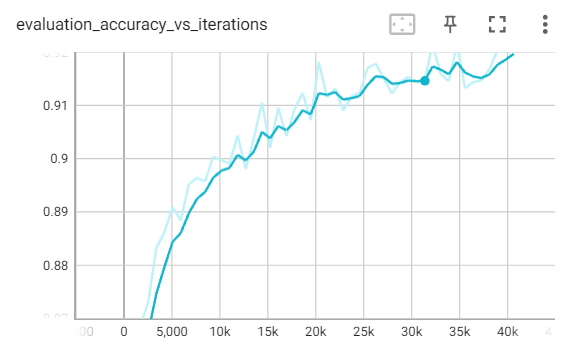

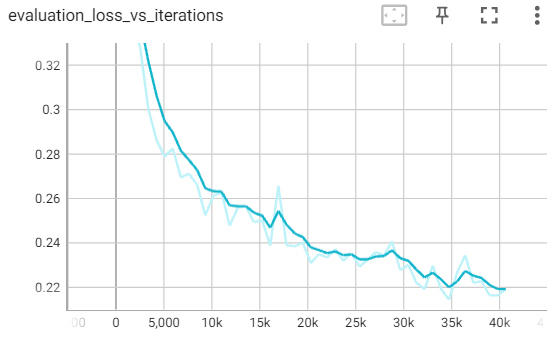

### Test result on my voice (male) and friend's voice (female)
```
1/1 [==============================] - 0s 18ms/step
Result: male
Probabilities::: Male: 97.20%    Female: 2.80%
1/1 [==============================] - 0s 16ms/step
Result: female
Probabilities::: Male: 13.83%    Female: 86.17%
```



## CNN Analysis

### Model Architecture and Parameters



```
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv1d_6 (Conv1D)           (None, 126, 64)           256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 dropout_51 (Dropout)        (None, 63, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 61, 128)           24704     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 dropout_52 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_7 (Flatten)         (None, 3840)              0         
                                                                 
 dense_68 (Dense)            (None, 128)               491648    
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_69 (Dense)            (None, 64)                8256      
...
Total params: 524,929
Trainable params: 524,929
Non-trainable params: 0
```



### Model Accuracy
Early stopping conditions (7 iterations without major improvements) met at Epoch 32.
```
Epoch 32/100
848/848 [==============================] - 5s 5ms/step - loss: 0.1304 - accuracy: 0.9519 - val_loss: 0.1368 - val_accuracy: 0.9552
```



In [ ]:
# evaluating the cnn model using the testing set
print(f"Evaluating the cnn model using {len(data['X_test'])} samples...")
loss, accuracy = cnn_model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the cnn model using 6694 samples...
Loss: 0.1261
Accuracy: 95.31%


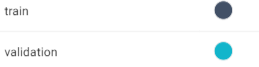

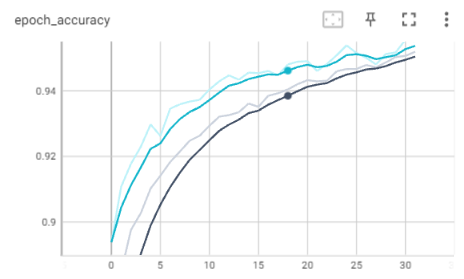

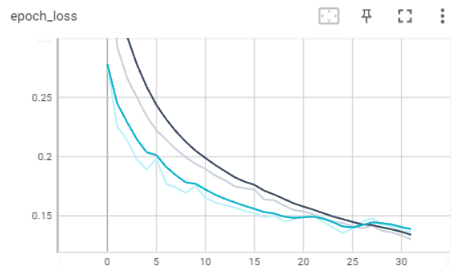

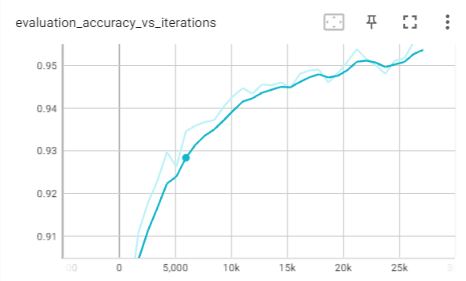

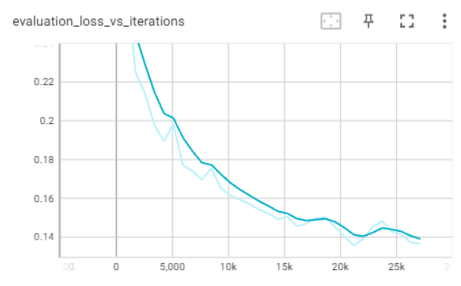

### Test result on my voice (male) and friend's voice (female)
```
1/1 [==============================] - 0s 85ms/step
Result: male
Probabilities::: Male: 99.91%    Female: 0.09%
1/1 [==============================] - 0s 24ms/step
Result: female
Probabilities::: Male: 46.00%    Female: 54.00%

```



## RNN Analysis

### Model Architecture and Parameters

```
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 simple_rnn_4 (SimpleRNN)    (None, 128, 128)          16640     
                                                                 
 dropout_60 (Dropout)        (None, 128, 128)          0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 64)                4160      
                                                                 
 dropout_62 (Dropout)        (None, 64)                0         
                                                                 
 dense_78 (Dense)            (None, 1)                 65        
                                                                 
=================================================================
Total params: 33,217
Trainable params: 33,217
Non-trainable params: 0
```



### Model Accuracy
Early stopping conditions (7 iterations without major improvements) met at Epoch 8.
```
Epoch 8/100
848/848 [==============================] - 223s 263ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5014
```



In [ ]:
# evaluating the model using the testing set
print(f"Evaluating the rnn model using {len(data['X_test'])} samples...")
loss, accuracy = rnn_model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the rnn model using 6694 samples...
Loss: 0.6840
Accuracy: 53.20%


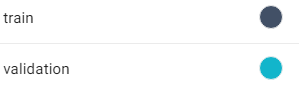

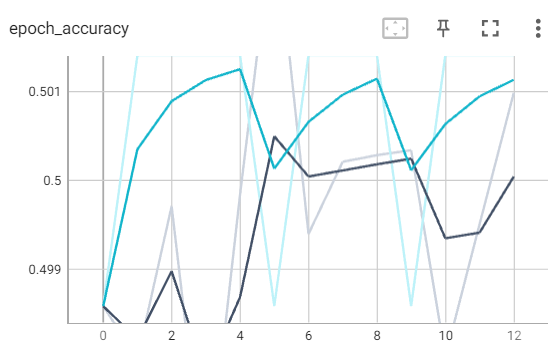

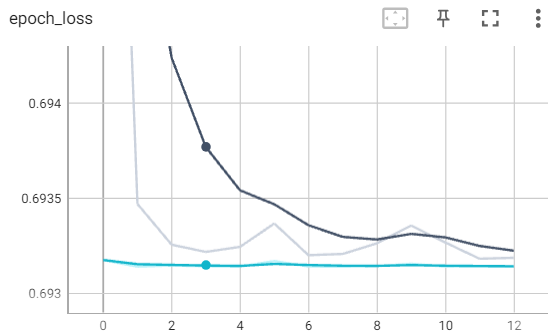

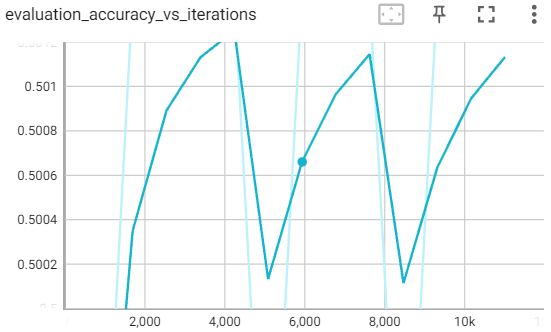

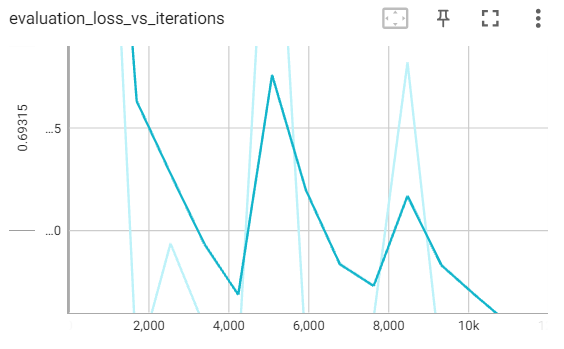

### Test result on my voice (male) and friend's voice (female)
```
1/1 [==============================] - 0s 207ms/step
Result: male
Probabilities::: Male: 51.02%    Female: 48.98%
1/1 [==============================] - 0s 49ms/step
Result: male
Probabilities::: Male: 51.02%    Female: 48.98%
```



## Transformer Analysis

### Model Architecture and Parameters



```
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_79 (Dense)               (None, 128)          16512       ['input_8[0][0]']                
                                                                                                  
 reshape_4 (Reshape)            (None, 128, 1)       0           ['dense_79[0][0]']               
                                                                                                  
 multi_head_attention_9 (MultiH  (None, 128, 1)      3585        ['reshape_4[0][0]',              
 eadAttention)                                                    'reshape_4[0][0]']              
                                                                                                  
 flatten_8 (Flatten)            (None, 128)          0           ['multi_head_attention_9[0][0]']
                                                                                                  
 dense_80 (Dense)               (None, 128)          16512       ['flatten_8[0][0]']              
                                                                                                  
 add_4 (Add)                    (None, 128)          0           ['dense_79[0][0]',               
                                                                  'dense_80[0][0]']               
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 128)         256         ['add_4[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_81 (Dense)               (None, 64)           8256        ['layer_normalization_3[0][0]']  
                                                                                                  
...
Total params: 45,186
Trainable params: 45,186
Non-trainable params: 0
```



### Model Accuracy
Early stopping conditions (7 iterations without major improvements) met at Epoch 22.
```
Epoch 22/100
848/848 [==============================] - 7s 8ms/step - loss: 0.1889 - accuracy: 0.9271 - val_loss: 0.2254 - val_accuracy: 0.9177
```



In [ ]:
# evaluating the model using the testing set
print(f"Evaluating the transformer model using {len(data['X_test'])} samples...")
loss, accuracy = t_model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the transformer model using 6694 samples...
Loss: 0.2122
Accuracy: 92.25%


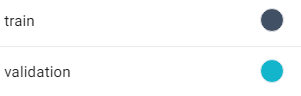

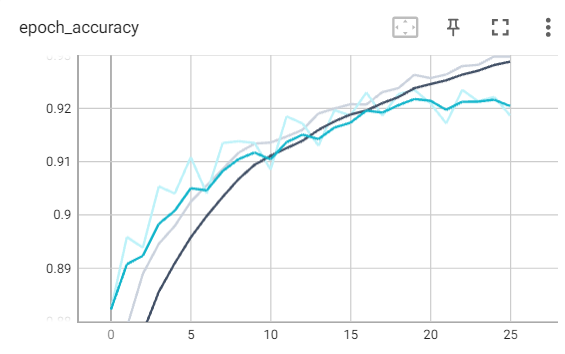

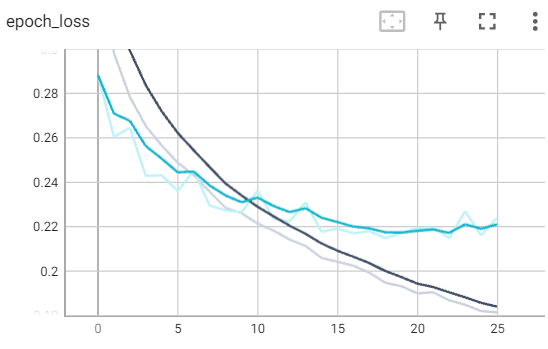
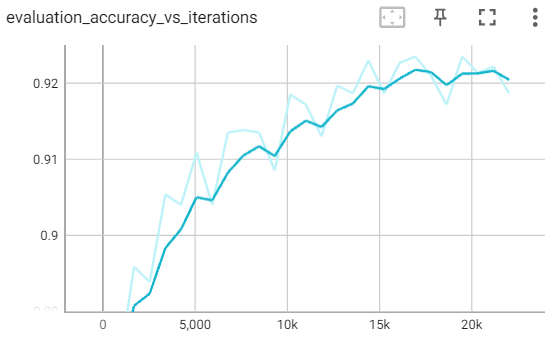
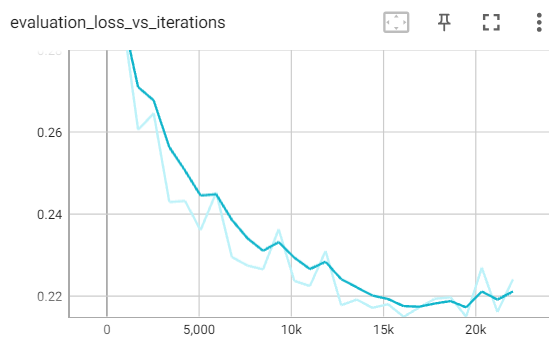

### Test result on my voice (male) and friend's voice (female)



```
1/1 [==============================] - 0s 105ms/step
Result: male
Probabilities::: Male: 96.30%    Female: 3.70%
1/1 [==============================] - 0s 17ms/step
Result: female
Probabilities::: Male: 29.35%    Female: 70.65%
```



# **Conclusion**

In this project, I evaluated four different models—MLP, CNN, RNN, and Transformer—to classify voice gender. Each model was trained and tested using a consistent dataset and evaluated based on loss, accuracy, and specific test cases involving my voice (male) and a friend's voice (female). The results from each model provide insight into their performance and suitability for this task.

*MLP (Multi-Layer Perceptron)*

The MLP model achieved a final accuracy of 92.01% with a loss of 0.2233. Early stopping was triggered after 48 epochs due to a lack of significant improvement. When tested on real-world data (my voice and a friend's voice), the model correctly classified both voices with high confidence, showing a probability distribution of 97.20% for male and 86.17% for female. The MLP model demonstrated robust performance across the board, showing balanced predictions with high confidence for both classes. This suggests that the MLP model effectively learned the features relevant to voice gender classification.

*CNN (Convolutional Neural Network)*


The CNN model performed slightly better than the MLP in terms of accuracy, achieving 95.31% with a lower loss of 0.1261. Early stopping was met at epoch 32. However, during the real-world testing, while the model correctly identified my voice as male with near certainty (99.91%), it struggled with my friend's voice, providing a less confident prediction (54% female). This suggests that while the CNN model is highly accurate, it might be overfitting to the training data or might struggle with certain variations in the voice, especially in distinguishing female voices.

*RNN (Recurrent Neural Network)*

The RNN model showed the poorest performance among the models, with an accuracy of 53.20% and a loss of 0.6840. Early stopping was triggered at a mere 8 epochs. In both test cases, the RNN was almost indifferent, predicting both voices with a nearly 50-50 probability split between male and female. This indicates that the RNN failed to capture the temporal dependencies in the data effectively and was unable to differentiate between male and female voices reliably. This could be due to insufficient training or an inherent limitation in how the RNN model was structured or trained.

*Transformer*

The Transformer model achieved a comparable accuracy to the MLP, with a slight edge at 92.25% and a loss of 0.2122. Early stopping occurred at 22 epochs. In the test cases, the Transformer performed well with my voice (96.30% male probability) but was less confident in classifying my friend's voice as female (70.65% female probability). While the Transformer showed promise, the confidence gap in real-world testing indicates potential instability in predictions, particularly for female voices.

**Final Model Selection**

Among the four models tested, the MLP model emerges as the most balanced and reliable for voice gender classification. Despite the CNN model achieving higher accuracy on the test data, its real-world performance was less stable, particularly in classifying female voices. The RNN model's poor performance highlights its unsuitability for this task, while the Transformer model, though promising, displayed some inconsistencies in confidence levels for different gender classifications.

The MLP's consistent and high-confidence predictions across both male and female voices, combined with its relatively simple architecture, make it the best choice for this task. The model's ability to generalize well to unseen data, as demonstrated by its robust real-world testing performance, further reinforces this decision. Therefore, the MLP model is selected as the final model for voice gender classification in this project.